# 1. Packages

In [1]:
import numpy as np
from numpy import array, zeros
import pandas as pd

from scipy.fftpack import dct, idct

import cv2
import matplotlib.pyplot as plt

import os
from tqdm.notebook import tqdm

from BATCH_DCT_DETECT import DCT_DETECT
# from utils import GetFeature, GetPathList, GetPlotDF, GetBalanceTrainArr

In [2]:
my_dct_detect = DCT_DETECT()

# 2. Image features

## 2.1. Generate features

In [9]:
train_data_path = "/home/re6091054/FF++/c40/train"

In [10]:
# with open("ff_train_raw.txt", "r") as f:
#     text = f.read()
# text = [sub_text.split(" ") for sub_text in text.split("\n")][:-1]

In [11]:
# Deepfakes_folder = [train_data_path + "/" + folder_name for folder_name, y in text][(180*0)+(720*0):(180*1)+(720*0)]
# Face2Face_folder = [train_data_path + "/" + folder_name for folder_name, y in text][(180*1)+(720*1):(180*2)+(720*1)]
# FaceSwap_folder = [train_data_path + "/" + folder_name for folder_name, y in text][(180*2)+(720*2):(180*3)+(720*2)]
# NeuralTextures_folder = [train_data_path + "/" + folder_name for folder_name, y in text][(180*3)+(720*3):(180*4)+(720*3)]
# Real_folder = [train_data_path + "/" + folder_name for folder_name, y in text][(720*4):]

In [12]:
# folder_list = [Deepfakes_folder, Face2Face_folder, FaceSwap_folder,  NeuralTextures_folder, Real_folder]

In [13]:
# features_list = []

In [14]:
# for folder_type in tqdm(folder_list):
#     images_list = []
#     for folder_path in folder_type:
#         images_list.append(cv2.imread(folder_path + "/0.png"))
#     features_list.append(my_dct_detect.main(images_list))

In [15]:
# features_arr = np.row_stack(features_list)

# response_arr = np.array(
#     [1] * 720 + 
#     [0] * 720
# )

# image_type_arr = np.array(
#     ["Deepfakes"] * 180 + 
#     ["Face2Face"] * 180 + 
#     ["FaceSwap"] * 180 + 
#     ["NeuralTextures"] * 180 + 
#     ["Real"] * 720
# )

In [16]:
# np.save("data/features_arr.npy", features_arr)
# np.save("data/response_arr.npy", response_arr)
# np.save("data/image_type_arr.npy", image_type_arr)

## 2.2. Load features

In [17]:
features_arr = np.load("data/features_arr.npy")
response_arr = np.load("data/response_arr.npy")
image_type_arr = np.load("data/image_type_arr.npy")

In [18]:
conv_features_arr = np.load("/home/re6091054/影像處理與電腦視覺/fianl_compression/data/train_features_Conv_trace_arr.npy")
conv_response_arr = np.load("/home/re6091054/影像處理與電腦視覺/fianl_compression/data/train_response_arr.npy")
conv_image_type_arr = np.load("/home/re6091054/影像處理與電腦視覺/fianl_compression/data/train_image_type_arr.npy")

In [20]:
conv_data_df = pd.concat([pd.DataFrame(conv_features_arr), pd.DataFrame(image_type_arr)], axis=1)
conv_data_df.columns = [str(i) for i in range(24)] + ['type']

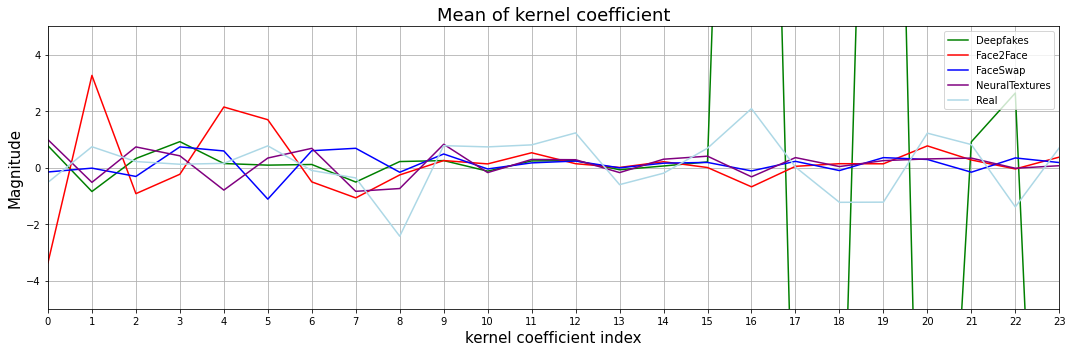

In [22]:
plt.figure(figsize=(15,5))
ax = pd.plotting.parallel_coordinates(
    frame=conv_data_df.groupby('type').mean().round(4).reset_index(),
    class_column='type',
    cols=[str(i) for i in range(24)],
    color=["green", "red", "blue", "purple", "lightblue"], axvlines=False,
)
ax.set_ylim(-5, 5)
ax.set_xlabel("kernel coefficient index", size=15)
ax.set_ylabel("Magnitude", size=15)
ax.set_title("Mean of kernel coefficient", size=18)
plt.tight_layout()
plt.show()

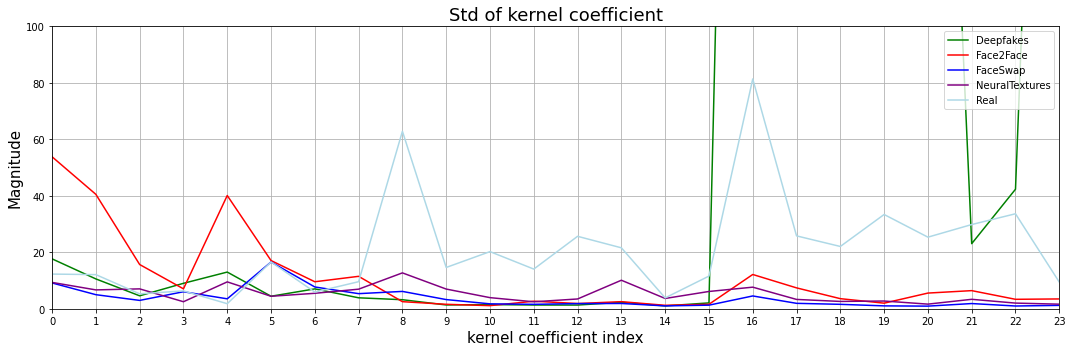

In [25]:
plt.figure(figsize=(15,5))
ax = pd.plotting.parallel_coordinates(
    frame=conv_data_df.groupby('type').std().round(4).reset_index(),
    class_column='type',
    cols=[str(i) for i in range(24)],
    color=["green", "red", "blue", "purple", "lightblue"], axvlines=False,
)
ax.set_ylim(0, 100)
ax.set_xlabel("kernel coefficient index", size=15)
ax.set_ylabel("Magnitude", size=15)
ax.set_title("Std of kernel coefficient", size=18)
plt.tight_layout()
plt.show()

In [18]:
cat_features_arr = np.column_stack([features_arr, conv_features_arr])

In [19]:
cat_features_arr.shape

(1440, 87)

# 5. Classifier

In [44]:
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, f1_score

## 5.1. Logistic regression

In [42]:
l_reg = LogisticRegression(penalty='l2', max_iter=2000)
l_reg.fit(cat_features_arr, response_arr)

LogisticRegression(max_iter=2000)

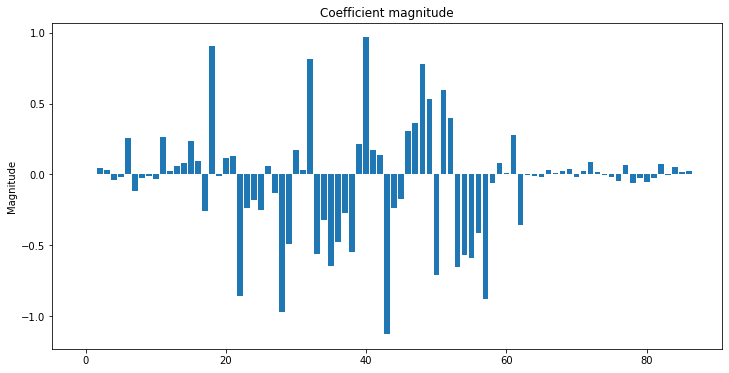

In [24]:
fig, ax = plt.subplots(figsize=(12,6))

ax.bar(list(range(87)), l_reg.coef_.reshape(-1))
ax.set_ylabel("Magnitude")
ax.set_title("Coefficient magnitude")
plt.show()

## 5.3. Xgboost

### 5.3.1. Data

In [25]:
xg_train = xgb.DMatrix(cat_features_arr, response_arr)

### 5.3.2. Model

In [26]:
params = {'objective':'binary:logistic', 'eval_metric':'logloss'}
xgb_model = xgb.train(params, xg_train, verbose_eval=True) # , 30, xgb_model=None

In [27]:
fpr, tpr, thresholds = roc_curve(response_arr, xgb_model.predict(xg_train), pos_label=1)
print("Train AUC", round(auc(fpr, tpr), 4), "\n")

Train AUC 0.9877 



In [28]:
# weight_ratio = float(len(train_y_001_array[train_y_001_array == 0])) / float(len(train_y_001_array[train_y_001_array == 1]))
# w_array = np.array([weight_ratio] * train_y_001_array.shape[0])
# w_array[train_y_001_array == 0] = 1- weight_ratio

# xgb_model.fit(X=train_x_001_array, y=train_y_001_array.astype(int), sample_weight=w_array)

In [29]:
# print("Testing ACC: ", round(accuracy_score(train_y_1, xgb_model.predict(train_x_1)), 4))
# print("Testing Confusion matrix: \n", confusion_matrix(train_y_1, xgb_model.predict(train_x_1)))

# 6. Test

In [30]:
test_data_path = '/home/re6091054/FF++/c40/test'

In [31]:
image_types = sorted(os.listdir(test_data_path))

In [32]:
# test_features_list = []

In [33]:
# for img_typ in tqdm(image_types):
#     type_name = test_data_path + "/" + img_typ
#     folders_list = os.listdir(type_name)
#     imags_list = []
#     for folder in folders_list:
#         folder_name = type_name + "/" + folder
#         imags_list.append(cv2.imread(folder_name + "/0.png"))
#     test_features_list.append(my_dct_detect.main(imags_list))

In [34]:
# list(map(lambda x: x.shape, test_features_list))

In [35]:
# test_features_arr = np.row_stack(test_features_list)
# test_response_arr = np.array(
#     [1] * 140 * 4 +
#     [0] * 140
# )
# test_image_type_arr = np.array(
#     ["Deepfakes"] * 140 + 
#     ["Face2Face"] * 140 + 
#     ["FaceSwap"] * 140 + 
#     ["NeuralTextures"] * 140 + 
#     ["Real"] * 140
# )

In [36]:
# np.save("data/test_features_arr.npy", test_features_arr)
# np.save("data/test_response_arr.npy", test_response_arr)
# np.save("data/test_image_type_arr.npy", test_image_type_arr)

In [37]:
test_features_arr = np.load("data/test_features_arr.npy")
test_response_arr = np.load("data/test_response_arr.npy")
test_image_type_arr = np.load("data/test_image_type_arr.npy")
test_conv_features_arr = np.load("/home/re6091054/影像處理與電腦視覺/fianl_compression/data/test_features_conv_trace_arr.npy")

In [38]:
test_cat_features_arr = np.column_stack([test_features_arr, test_conv_features_arr])

In [45]:
print("Testing ACC: ", round(accuracy_score(l_reg.predict(test_cat_features_arr), test_response_arr), 4), "\n")
print("Testing confusion matrix: \n", confusion_matrix(l_reg.predict(test_cat_features_arr), test_response_arr), "\n")

fpr, tpr, thresholds = roc_curve(test_response_arr, l_reg.predict_proba(test_cat_features_arr)[:,1], pos_label=1)
print("Testing AUC", round(auc(fpr, tpr), 4), "\n")

print("F1: ", f1_score(test_response_arr, l_reg.predict(test_cat_features_arr), average='macro'))

Testing ACC:  0.5557 

Testing confusion matrix: 
 [[ 76 247]
 [ 64 313]] 

Testing AUC 0.5632 

F1:  0.49819169215662323


In [39]:
xg_test = xgb.DMatrix(test_cat_features_arr, test_response_arr)

In [40]:
test_pred_prob = xgb_model.predict(xg_test)
test_pred = np.round(test_pred_prob)

In [46]:
print("Testing ACC: ", round(accuracy_score(test_pred, test_response_arr), 4), "\n")
print("Testing confusion matrix: \n", confusion_matrix(test_pred, test_response_arr), "\n")

fpr, tpr, thresholds = roc_curve(test_response_arr, test_pred_prob, pos_label=1)
print("Testing AUC", round(auc(fpr, tpr), 4), "\n")

print("F1: ", f1_score(test_response_arr, test_pred, average='macro'))

Testing ACC:  0.5429 

Testing confusion matrix: 
 [[ 62 242]
 [ 78 318]] 

Testing AUC 0.5166 

F1:  0.472275622903238
